In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# characters_talents = pd.read_csv('game_data/Character.Talents.Info.csv')

In [3]:
os.makedirs('processed_game_data', exist_ok=True)
characters_info = pd.read_csv('game_data/Character.Info2.csv').filter(['ID', 'RaceID', 'Speed']).drop_duplicates()
tmp = pd.read_csv('game_data/Character.Levels.Stats.csv')
characters_info = pd.merge(characters_info, tmp, on='ID')
tmp = pd.read_csv('game_data/Character.Levels.Info.csv').filter(['Level', 'RequiredTokens'])
characters_info = pd.merge(characters_info, tmp, on='Level')
characters_info['nft'] = characters_info['ID'].str.startswith('NFT_')
tmp = pd.read_csv('game_data/PricePool.csv')
tmp1 = tmp[(tmp['ID'].str.startswith('price_ch_upgrade_lvl_')) & (tmp['ItemID']=='Shards')]
tmp1['Level'] = tmp1['ID'].str.extract('(\d+)')
tmp1['Level'] = tmp1['Level'].astype(int)
tmp1['nft'] = False
tmp1 = tmp1.rename(columns={'Amount': 'Shards'})
tmp1['Crown'] = 0
tmp1 = tmp1.filter(['Level', 'Shards', 'Crown', 'nft'])
tmp2 = tmp[tmp['ID'].str.startswith('price_ch_nft_upgrade_lvl_')]
tmp2['Level'] = tmp2['ID'].str.extract('(\d+)')
tmp2['Level'] = tmp2['Level'].astype(int)
tmp2 = tmp2.filter(['Level', 'ItemID', 'Amount'])
tmp2 = tmp2.pivot(index='Level', columns='ItemID', values='Amount').reset_index()
tmp2['nft'] = True
tmp = pd.concat([tmp1, tmp2])
characters_info = pd.merge(characters_info, tmp, on=['Level', 'nft'])
characters_upgrade = characters_info.filter(['Level', 'RequiredTokens', 'Shards', 'Crown', 'nft']).rename(columns={'RequiredTokens': 'Tokens'}).drop_duplicates()
characters_info = characters_info.drop(columns=['RequiredTokens', 'Shards', 'Crown'])
characters_upgrade.to_csv('processed_game_data/characters_upgrade.csv', index=False)
characters_info = characters_info[~characters_info['ID'].isin(['NFT_Shark_Bronze', 'NFT_Shark_Silver'])]
def foo(row):
    names = {
        'Ape': 'Rocky',
        'Bear': 'Bonnie',
        'Cat': 'Cranky',
        'Tiger': 'Alex',
        'Croco': 'Aldo',
        'Rabbit': 'Lola',
        'Snail': 'Zoom',
        'Shark': 'Finn',
        'Squirrel': 'Zayn',
        'Bull': 'Brutus',
        'Chicken': 'Chicken'
    }
    if row['ID'].startswith('FREE_'):
        return names[row['RaceID']]
    if row['ID'].startswith('NFT_Ape'):
        return row['ID'].split('_')[-1] + ' Genesis Ape'
    if row['ID'].startswith('NFT_Shark'):
        return row['ID'].split('_')[-1] + ' Space Shark'
    return np.nan
characters_info['ID'] = characters_info.apply(foo, axis=1)
characters_info = characters_info.rename(columns={'ID': 'Name', 'RaceID': 'Race'})
characters_info.to_csv('processed_game_data/characters_info.csv', index=False)

/tmp/ipykernel_927517/2670890416.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Level'] = tmp1['ID'].str.extract('(\d+)')
/tmp/ipykernel_927517/2670890416.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Level'] = tmp1['Level'].astype(int)
/tmp/ipykernel_927517/2670890416.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

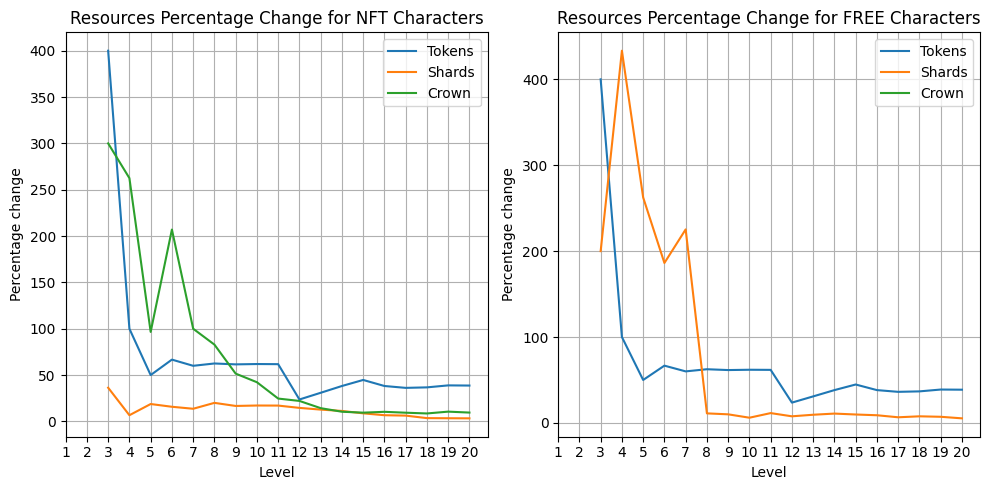

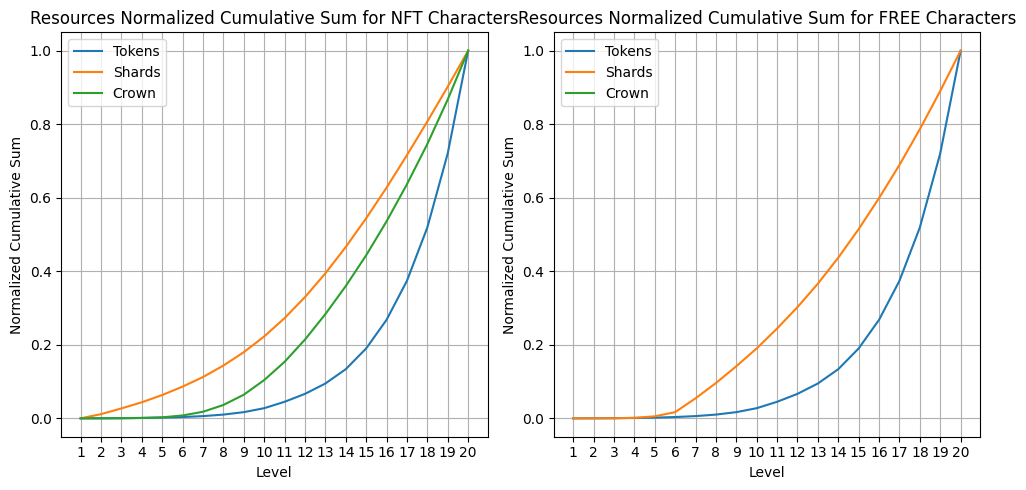

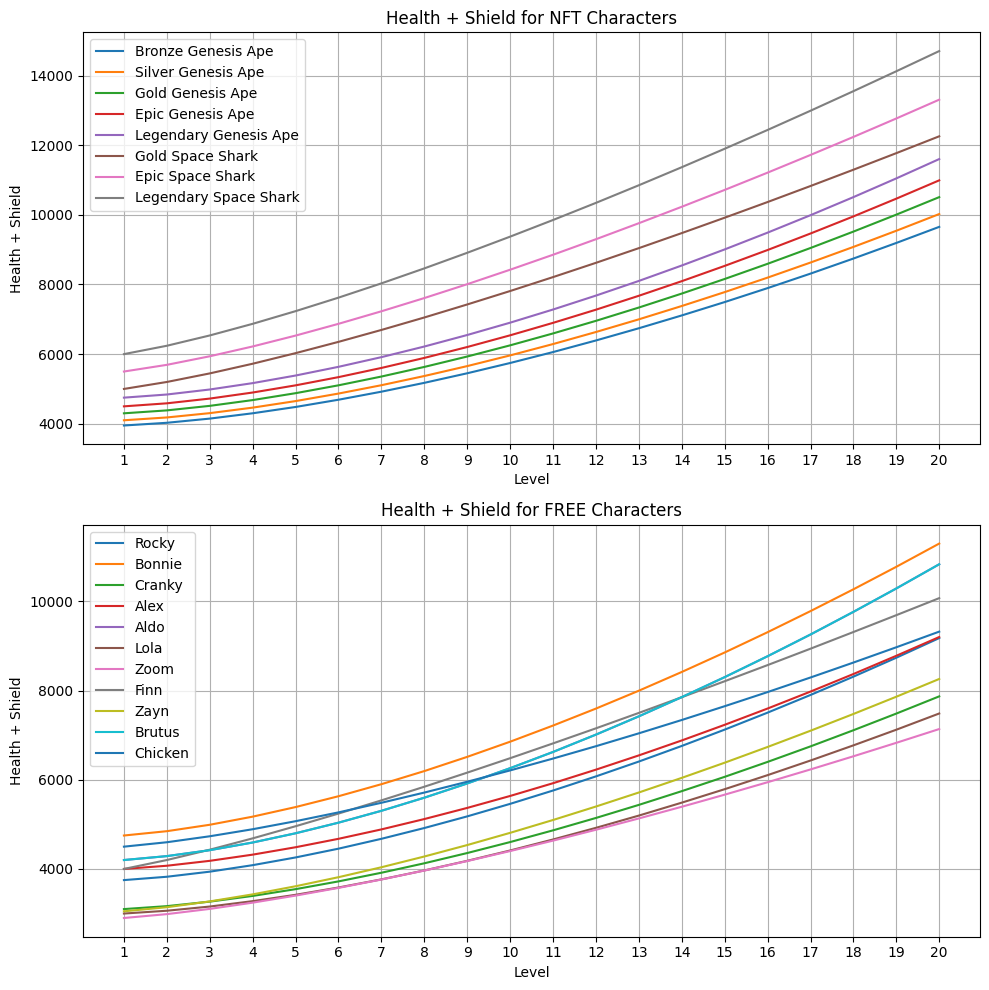

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, nft in enumerate([True, False]):
    tmp1 = characters_upgrade[characters_upgrade['nft'] == nft].sort_values('Level')
    tmp1['TokensIncrementperc'] = round(tmp1['Tokens'].pct_change() * 100, 2)
    tmp1['ShardsIncrementperc'] = round(tmp1['Shards'].pct_change() * 100, 2)
    tmp1['CrownIncrementperc'] = round(tmp1['Crown'].pct_change() * 100, 2)
    for col in ['Tokens', 'Shards', 'Crown']:
        axes[i].plot(tmp1['Level'], tmp1[col+"Incrementperc"], label=col)
    axes[i].legend()
    axes[i].set_xlabel('Level')
    axes[i].grid(True)
    axes[i].set_xticks(tmp1['Level'])
    axes[i].set_ylabel('Percentage change')
    nftstring = 'NFT' if nft else 'FREE'
    axes[i].set_title(f'Resources Percentage Change for {nftstring} Characters')
plt.tight_layout()
plt.savefig('images/characters_resources_percentage_change.png', dpi=200)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, nft in enumerate([True, False]):
    tmp1 = characters_upgrade[characters_upgrade['nft'] == nft].sort_values('Level')
    tmp1['TokensCum'] = tmp1['Tokens'].cumsum()
    tmp1['ShardsCum'] = tmp1['Shards'].cumsum()
    tmp1['CrownCum'] = tmp1['Crown'].cumsum()
    tmp1['TokensIncrementPercent'] = round(tmp1['Tokens'] / tmp1['TokensCum'] * 100, 2)
    tmp1['ShardsIncrementPercent'] = round(tmp1['Shards'] / tmp1['ShardsCum'] * 100, 2)
    tmp1['CrownIncrementPercent'] = round(tmp1['Crown'] / tmp1['CrownCum'] * 100, 2)
    for col in ['Tokens', 'Shards', 'Crown']:
        colnormalized = tmp1[col + 'Cum'] / tmp1[col].sum()
        axes[i].plot(tmp1['Level'], colnormalized, label=col)
    axes[i].legend()
    axes[i].set_xlabel('Level')
    axes[i].grid(True)
    axes[i].set_xticks(tmp1['Level'])
    axes[i].set_ylabel('Normalized Cumulative Sum')
    nftstring = 'NFT' if nft else 'FREE'
    axes[i].set_title(f'Resources Normalized Cumulative Sum for {nftstring} Characters')
plt.tight_layout()
plt.savefig('images/characters_resources_cumsum.png', dpi=200)
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
for i, nft in enumerate([True, False]):
    for character in characters_info[characters_info['nft'] == nft]['Name'].unique():
        tmp = characters_info[characters_info['Name'] == character].sort_values('Level')
        data = tmp['Health'] + tmp['Shield']
        axes[i].plot(tmp['Level'], data, label=character)
    axes[i].legend()
    axes[i].set_xticks(tmp['Level'])
    axes[i].set_xlabel('Level')
    axes[i].set_ylabel('Health + Shield')
    axes[i].set_title(f'Health + Shield for {"NFT" if nft else "FREE"} Characters')
    axes[i].grid(True)
plt.tight_layout()
plt.savefig('images/characters_health_shield.png', dpi=200)
plt.show()


In [5]:
def fix_modifier_weapon_reloadTime_mul(value):
    if value < 1:
        return value
    return 2-value
weaponData = pd.read_csv('game_data/Weapon.Data.csv')
weaponInfo = pd.read_csv('game_data/Weapon.Info.csv')
weaponInfo_dict = {}
for weapon_type in weaponInfo['WeaponType'].unique():
    weaponInfo_dict[weapon_type] = {}
    for _, row in weaponInfo[weaponInfo['WeaponType']==weapon_type].iterrows():
        weaponInfo_dict[weapon_type][row['StatType']] = row['StatValue']
weaponInfo = pd.DataFrame.from_dict(weaponInfo_dict, orient='index').reset_index().rename(columns={'index': 'WeaponType'})
weaponInfo.to_csv('processed_game_data/weapon_params.csv', index=False)
weaponInfo = weaponInfo.drop(columns=weaponInfo.columns[weaponInfo.isna().any()].tolist())
weaponData = weaponData.filter(['ID', 'WeaponType', 'CollectionID', 'StarLevel', 'IsNFT', 'DamageIncrease'])
weaponInfo = pd.merge(weaponInfo, weaponData, on='WeaponType').drop(columns=['WeaponType'])
weaponInfo['level'] = 1
for lvl in range(2, 21):
    tmp = weaponInfo[weaponInfo['level']==1]
    tmp['level'] = lvl
    tmp['weapon_damage'] = tmp.apply(lambda row: float(row['weapon_damage']) + float(row['DamageIncrease'])*(lvl-1), axis=1)
    weaponInfo = pd.concat([weaponInfo, tmp])
weaponInfo = weaponInfo.drop(columns=['DamageIncrease'])
weaponInfo.to_csv('processed_game_data/weapon_info.csv', index=False)
weaponInfo = pd.read_csv('processed_game_data/weapon_info.csv')
tmp = pd.read_csv('game_data/Weapon.Data.csv').filter(['ID', 'StatType', 'StatValue'])
tmp['StarLevel'] = tmp['ID'].str.extract('(\d+)')
tmp['StarLevel'] = tmp['StarLevel'].astype(int)
tmp = tmp.sort_values('StarLevel')
for i, row in tmp.iterrows():
    statType = row['StatType']
    statValue = row['StatValue']
    starLevel = row['StarLevel']
    id = '_'.join(row['ID'].split('_')[:-1])
    if statType == 'weapon_damage':
        weaponInfo['weapon_damage'] = weaponInfo.apply(lambda x: x['weapon_damage'] + statValue if x['StarLevel']>=starLevel and '_'.join(x['ID'].split('_')[:-1])==id else x['weapon_damage'], axis=1)
    if statType == 'weapon_projectile_range':
        weaponInfo['weapon_projectile_range'] = weaponInfo.apply(lambda x: x['weapon_projectile_range'] + statValue if x['StarLevel']>=starLevel and '_'.join(x['ID'].split('_')[:-1])==id else x['weapon_projectile_range'], axis=1)
    if statType == 'modifier_weapon_damage_mul':
        weaponInfo['weapon_damage'] = weaponInfo.apply(lambda x: x['weapon_damage'] * statValue if x['StarLevel']>=starLevel and '_'.join(x['ID'].split('_')[:-1])==id else x['weapon_damage'], axis=1)
    if statType == 'modifier_weapon_reloadTime_mul':
        weaponInfo['weapon_reloadTime'] = weaponInfo.apply(lambda x: x['weapon_reloadTime'] * fix_modifier_weapon_reloadTime_mul(statValue) if x['StarLevel']>=starLevel and '_'.join(x['ID'].split('_')[:-1])==id else x['weapon_reloadTime'], axis=1)
    if statType == 'modifier_weapon_projectile_speed_mul':
        weaponInfo['weapon_projectile_speed'] = weaponInfo.apply(lambda x: x['weapon_projectile_speed'] * statValue if x['StarLevel']>=starLevel and '_'.join(x['ID'].split('_')[:-1])==id else x['weapon_projectile_speed'], axis=1)
names = {
    'AssaultGun Default': 'Blaster',
    'Shotgun Default': 'Boomstick',
    'RailGun Default': 'Railgun',
    'MortarGun Default': 'Mortar Gun',
    'TeslaGun Default': 'Tesla Gun',
    'AssaultGun Arsenal-X': 'Blaster-X',
    'Shotgun Arsenal-X': 'Boomstick-X',
    'RailGun Arsenal-X': 'Railgun-X',
    'MortarGun Arsenal-X': 'Mortar Gun X',
    'TeslaGun Arsenal-X': 'Tesla Gun X',
    'Hammer Mythical': 'Skybreaker',
    'RocketLauncher Mythical': 'Hellfire Launcher',
    'Flamer Mythical': 'Dragonbreath',
    'Minigun Mythical': 'Titan Shredder',
    'Spreadgun Mythical': 'Helios Cannon',
    'Crossbow Mythical': 'Wrath Of Artemis'
}
weaponInfo['name'] = weaponInfo['ID'].apply(lambda x: names[' '.join(x.split('_')[1:-1])])
weaponInfo = weaponInfo.drop(columns=['ID'])
weaponInfo.to_csv('processed_game_data/weapon_info.csv', index=False)

/tmp/ipykernel_927517/1888675051.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['level'] = lvl
/tmp/ipykernel_927517/1888675051.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['weapon_damage'] = tmp.apply(lambda row: float(row['weapon_damage']) + float(row['DamageIncrease'])*(lvl-1), axis=1)


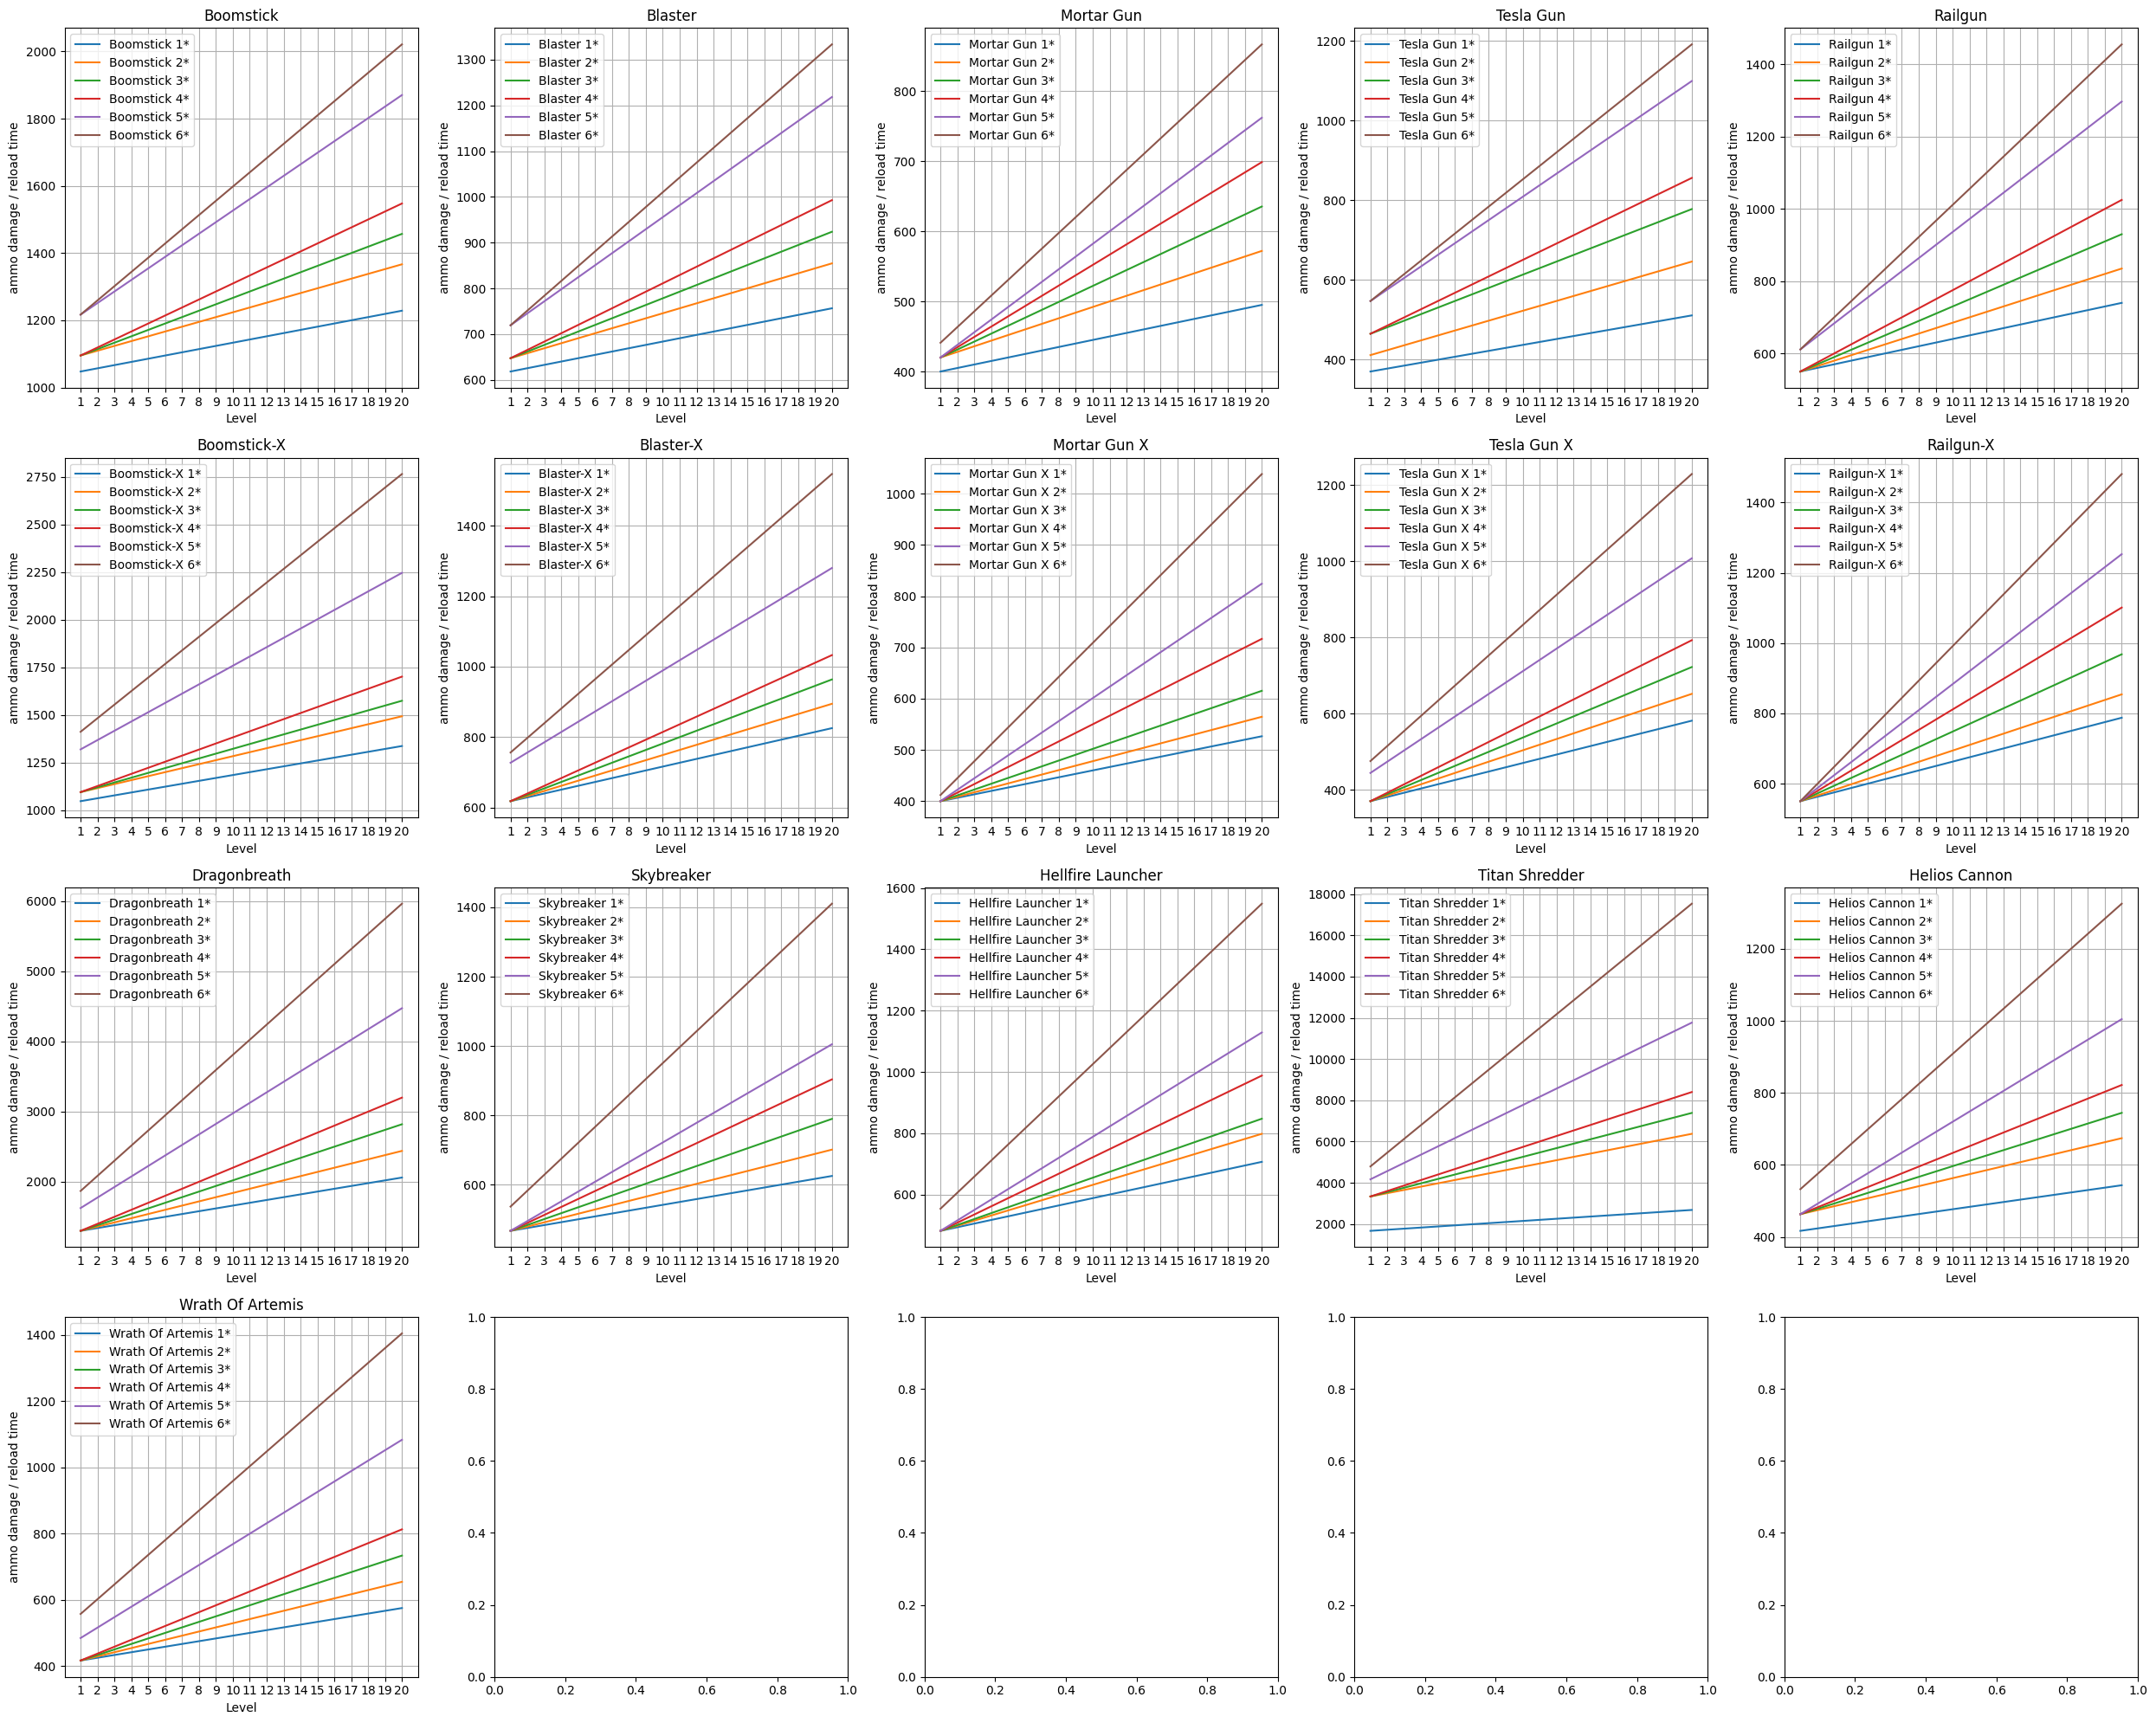

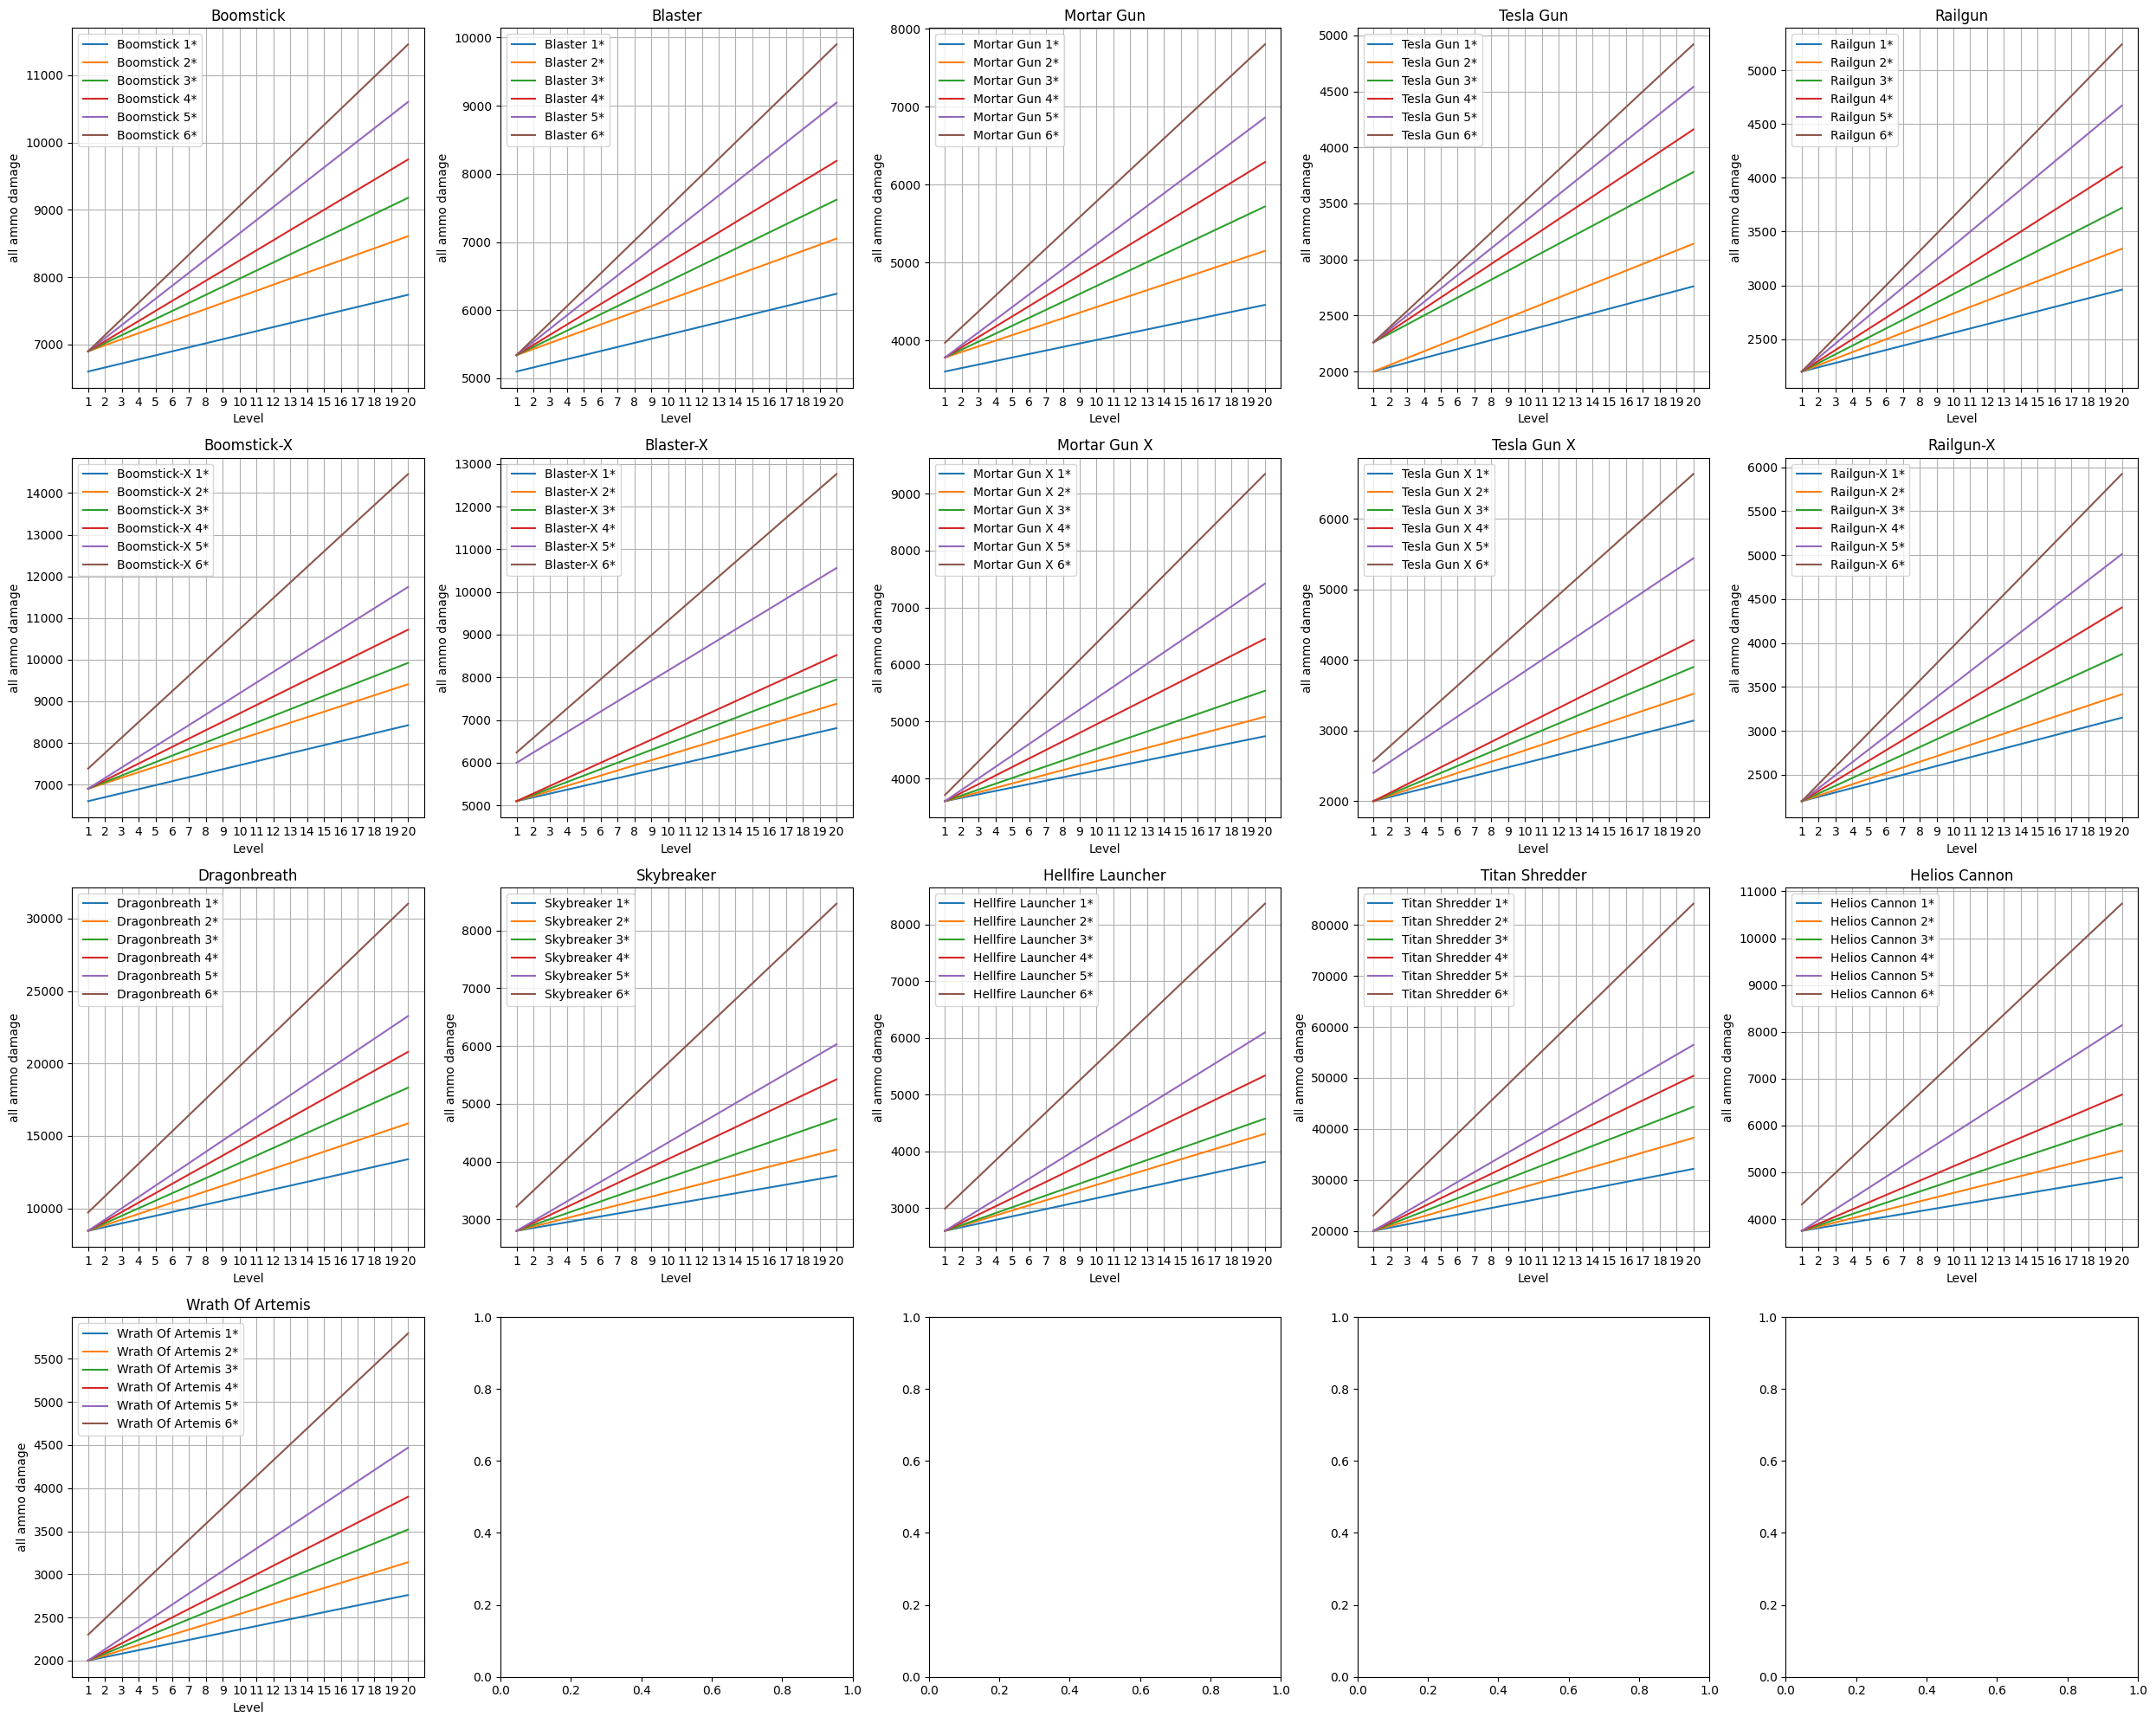

In [6]:
fig, axs = plt.subplots(4, 5, figsize=(25, 20))
i = 0
j = 0
for collection in weaponInfo['CollectionID'].unique():
    for name in weaponInfo[weaponInfo['CollectionID']==collection]['name'].unique():
        for starLevel in weaponInfo[weaponInfo['name']==name]['StarLevel'].unique():
            tmp = weaponInfo[(weaponInfo['name']==name) & (weaponInfo['StarLevel']==starLevel) & (weaponInfo['CollectionID']==collection)]
            axs[i, j].plot(tmp['level'], tmp['weapon_damage']/tmp['weapon_reloadTime'], label=name+' '+str(starLevel)+'*')
        axs[i, j].set_title(name)
        axs[i, j].legend()
        axs[i, j].grid()
        axs[i, j].set_xlabel('Level')
        axs[i, j].set_ylabel('ammo damage / reload time')
        axs[i, j].set_xticks(range(1, 21))
        j += 1
        if j == 5:
            j = 0
            i += 1
plt.tight_layout()
plt.savefig('images/weapons_ammo_damage_over_reload_time.png', dpi=200)
plt.show()
plt.close()

fig, axs = plt.subplots(4, 5, figsize=(25, 20))
i = 0
j = 0
for collection in weaponInfo['CollectionID'].unique():
    for name in weaponInfo[weaponInfo['CollectionID']==collection]['name'].unique():
        for starLevel in weaponInfo[weaponInfo['name']==name]['StarLevel'].unique():
            tmp = weaponInfo[(weaponInfo['name']==name) & (weaponInfo['StarLevel']==starLevel) & (weaponInfo['CollectionID']==collection)]
            axs[i, j].plot(tmp['level'], tmp['weapon_damage']*tmp['weapon_ammo'], label=name+' '+str(starLevel)+'*')
        axs[i, j].set_title(name)
        axs[i, j].legend()
        axs[i, j].grid()
        axs[i, j].set_xlabel('Level')
        axs[i, j].set_ylabel('all ammo damage')
        axs[i, j].set_xticks(range(1, 21))
        j += 1
        if j == 5:
            j = 0
            i += 1
plt.tight_layout()
plt.savefig('images/weapons_all_ammo_damage.png', dpi=200)
plt.show()
plt.close()

In [7]:
weapons_upgrade = pd.read_csv('game_data/Weapon.Levels.csv')
tmp = pd.read_csv('game_data/PricePool.csv')
tmp1 = tmp[(tmp['ID'].str.startswith('price_wp_upgrade_lvl_')) & (tmp['ItemID']=='Shards')]
tmp1['Level'] = tmp1['ID'].str.extract('(\d+)')
tmp1['Level'] = tmp1['Level'].astype(int)
tmp1['nft'] = False
tmp1 = tmp1.rename(columns={'Amount': 'Shards'})
tmp1['Crown'] = 0
tmp1 = tmp1.filter(['Level', 'Shards', 'Crown', 'nft'])
tmp2 = tmp[tmp['ID'].str.startswith('price_wp_nft_upgrade_lvl_')]
tmp2['Level'] = tmp2['ID'].str.extract('(\d+)')
tmp2['Level'] = tmp2['Level'].astype(int)
tmp2 = tmp2.filter(['Level', 'ItemID', 'Amount'])
tmp2 = tmp2.pivot(index='Level', columns='ItemID', values='Amount').reset_index()
tmp2['nft'] = True
tmp = pd.concat([tmp1, tmp2])
weapons_upgrade = pd.merge(weapons_upgrade, tmp, on='Level')
weapons_upgrade = weapons_upgrade.rename(columns={'XPNeeded': 'Tokens'})
weapons_upgrade = weapons_upgrade.filter(['Level', 'Tokens', 'Shards', 'Crown', 'nft'])
weapons_upgrade = weapons_upgrade.drop_duplicates().sort_values(['nft', 'Level'])
weapons_upgrade.to_csv('processed_game_data/weapons_upgrade.csv', index=False)

/tmp/ipykernel_927517/266754270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Level'] = tmp1['ID'].str.extract('(\d+)')
/tmp/ipykernel_927517/266754270.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['Level'] = tmp1['Level'].astype(int)
/tmp/ipykernel_927517/266754270.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

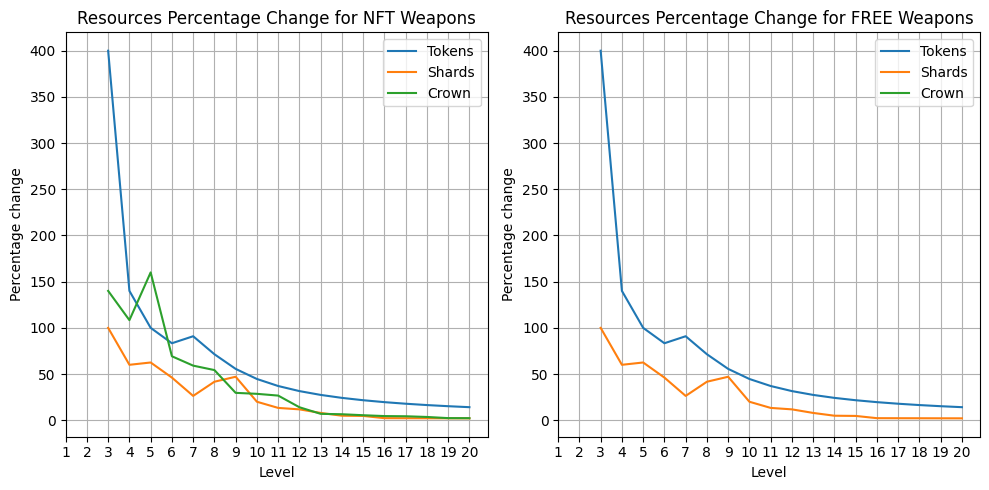

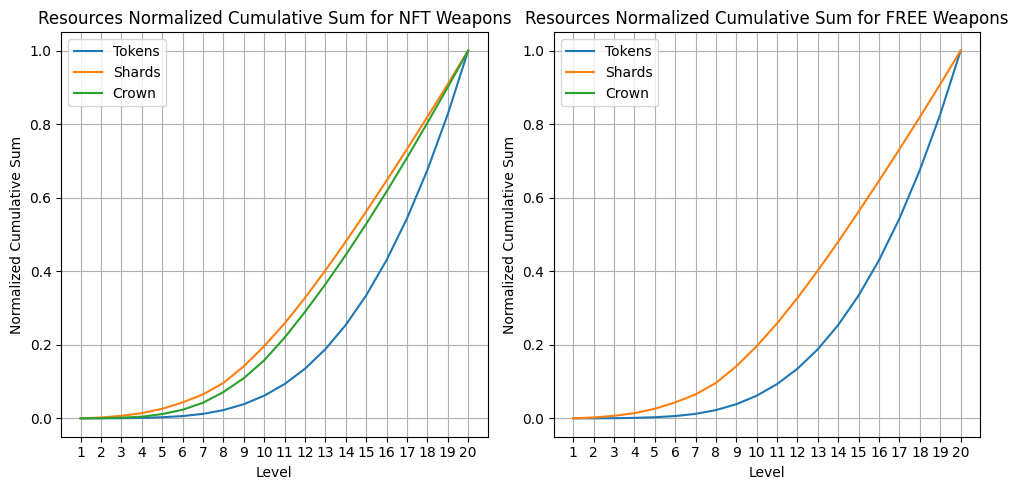

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, nft in enumerate([True, False]):
    tmp1 = weapons_upgrade[weapons_upgrade['nft'] == nft].sort_values('Level')
    tmp1['TokensIncrementperc'] = round(tmp1['Tokens'].pct_change() * 100, 2)
    tmp1['ShardsIncrementperc'] = round(tmp1['Shards'].pct_change() * 100, 2)
    tmp1['CrownIncrementperc'] = round(tmp1['Crown'].pct_change() * 100, 2)
    for col in ['Tokens', 'Shards', 'Crown']:
        axes[i].plot(tmp1['Level'], tmp1[col+"Incrementperc"], label=col)
    axes[i].legend()
    axes[i].set_xlabel('Level')
    axes[i].grid(True)
    axes[i].set_xticks(tmp1['Level'])
    axes[i].set_ylabel('Percentage change')
    nftstring = 'NFT' if nft else 'FREE'
    axes[i].set_title(f'Resources Percentage Change for {nftstring} Weapons')
plt.tight_layout()
plt.savefig('images/weapons_resources_percentage_change.png', dpi=200)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, nft in enumerate([True, False]):
    tmp1 = weapons_upgrade[weapons_upgrade['nft'] == nft].sort_values('Level')
    tmp1['TokensCum'] = tmp1['Tokens'].cumsum()
    tmp1['ShardsCum'] = tmp1['Shards'].cumsum()
    tmp1['CrownCum'] = tmp1['Crown'].cumsum()
    tmp1['TokensIncrementPercent'] = round(tmp1['Tokens'] / tmp1['TokensCum'] * 100, 2)
    tmp1['ShardsIncrementPercent'] = round(tmp1['Shards'] / tmp1['ShardsCum'] * 100, 2)
    tmp1['CrownIncrementPercent'] = round(tmp1['Crown'] / tmp1['CrownCum'] * 100, 2)
    for col in ['Tokens', 'Shards', 'Crown']:
        colnormalized = tmp1[col + 'Cum'] / tmp1[col].sum()
        axes[i].plot(tmp1['Level'], colnormalized, label=col)
    axes[i].legend()
    axes[i].set_xlabel('Level')
    axes[i].grid(True)
    axes[i].set_xticks(tmp1['Level'])
    axes[i].set_ylabel('Normalized Cumulative Sum')
    nftstring = 'NFT' if nft else 'FREE'
    axes[i].set_title(f'Resources Normalized Cumulative Sum for {nftstring} Weapons')
plt.tight_layout()
plt.savefig('images/weapons_resources_cumsum.png', dpi=200)
plt.show()